In [34]:
import ast
import csv
import os
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from sklearn import model_selection
import scikitplot as skplt
import matplotlib.pyplot as plt

In [ ]:
!pip install skle

In [2]:
def getFiles(organName, listDir, prefix=None):
    """
    Generate list of files associa-
    ted with each organ of interest
    in the list of files.
    --------------------------
    Input:
        organ_list: list of organs
                    str
        listDir:    list of files  
                    to search
        prefix:     OS path prefix
    Output:
        lists:      list of files 
                    associated with
                    organ
    """
    # get the files from listDir that contain 'organName'
    matching = [file for file in listDir if organName in file]
    
    # append the path prefix so that files are accessible
    if prefix:
        matchingFixed = [prefix + file for file in matching]
        return matchingFixed
    
    else:
        return matching

In [3]:
def filestoDF(file_list):
    """
    Return a list of data frames from the given
    list of files.
    """
    dfs = [pd.read_csv(file, low_memory=False) for file in file_list]
    return dfs

## Classifier Code
by Travis Zack
- `RandomForestClassifier`:
    - Tailored to either binary or multilabel per users' choice.

In [43]:
class Classifier:
    def __init__(self, labels, multilabel=False):
        # boolean, if multilabel (T/F)
        self.multilabel = multilabel 
        # initialize model (RF), method below
        self.model = self.initialize_model() 
        
        # set labels ['Present', 'Absent'] or multilabels
        self.labels = labels 
        # idx each label in a dictionary key: label, val: idx
        self.label2idx = {l: i for i, l in enumerate(self.labels)}

    def initialize_model(self):
        # model is random forest, n=-1 means use all available
        # processors (parallel)
        model = RandomForestClassifier(verbose=False, n_jobs=-1)
        # if true in multilabel, 
        if self.multilabel:
            # make it multilabel: one classifier (assign a label
            # to data point) per target, estimator (first param)
            # is the model at hand (random forest here)
            model = MultiOutputClassifier(model, n_jobs=-1)
        
        model = make_pipeline(TfidfVectorizer(ngram_range=(1, 5)), model)
        return model

    def fit(self, X, y):
        # first fix depending on multilabel or binary
        
        # if not False: then its true, then binary
        if not self.multilabel:
            y = np.ravel(y)
            # idx at label
            y = [self.label2idx[i] for i in y]
        # otherwise multilabel
        else:
            multilabel_idx = np.zeros(shape=(len(X), len(self.labels)))
            for i, cur_labels in enumerate(y):
                for cur_label in cur_labels:
                    multilabel_idx[i, self.label2idx.get(cur_label)] = 1
            y = multilabel_idx
            
        # now call on random forest fit method once y is appropriately
        # constructed
        return self.model.fit(X, y)

    def predict(self, X):
        # get model probability predictions
        probabilities = self.model.predict_proba(X)
        
        # if binary
        if not self.multilabel:
            # idx of the max probability in label
            predicted_label_indices = np.argmax(probabilities, axis=1)
            # predicted scores for each
            predicted_scores = probabilities[np.arange(len(predicted_label_indices)), predicted_label_indices]
        # else it is multilabel
        else:
            # difference of this predict vs the predict proba?
            predicted_label_indices = self.model.predict(X)
            # redefine the var probabilities, this is mainly to deal with the prob outputs of multilabel
            # should work bc the model was already altered to be multilabel
            probabilities = [np.max(i, axis=1) for i in probabilities]
            probabilities = np.stack(probabilities, axis=1)

            # Using maximum confidence over all labels as the classifier confidence, since random forest
            predicted_scores = np.max(probabilities, axis=1)

        predictions, scores = list(), list()
        for idx, score in zip(predicted_label_indices, predicted_scores):
            if not self.multilabel:
                predicted_labels = [self.labels[idx]]
            else:
                predicted_labels = idx # [self.labels[i] for i, j in enumerate(idx) if int(j) == 1]
            predictions.append(predicted_labels)

        return predictions, predicted_scores, probabilities

### Computing Metrics
F1 and accuracy score from sklearn metrics.

In [48]:
def compute_metrics(y_gold, y_pred):
    macro_f1 = f1_score(y_true=y_gold, y_pred=y_pred, average='macro')
    micro_f1 = f1_score(y_true=y_gold, y_pred=y_pred, average='micro')
    acc = accuracy_score(y_true=y_gold, y_pred=y_pred)

    return macro_f1, micro_f1, acc

### Defining Directories

In [7]:
base_dir = '../../Report_learning_files'
annotate_folder = base_dir + '/manual_annotation/'

# read files
df_ga_annot = pd.read_csv(annotate_folder + 'ga_on_tx_Liver_manual_annotation.csv')
df_ffx_annot = pd.read_csv(annotate_folder + 'ffx_baseline_Liver_annotation.csv')

df_dev_annot = pd.read_csv(annotate_folder + 'dev_disease_location_Liver.csv')
df_train_annot = pd.read_csv(annotate_folder + 'train_disease_location_Liver.csv')

results_dir = '../../Results_Silvia/'

### Generate X, y and idx data

In [8]:
# dev data X, y and idx
idxes_dev = df_dev_annot['idx'].tolist()
y_dev = [i[2:len(i)-2] for i in df_dev_annot['label'].tolist()]
X_dev = df_dev_annot['sentence'].tolist()

# train data X,y and idx
idxes_train = df_train_annot['idx'].tolist()
y_train= [i[2:len(i)-2] for i in df_train_annot['label'].tolist()]
X_train = df_train_annot['sentence'].tolist()

In [9]:
# split other files between dev and train data 
ffx_train, ffx_dev = train_test_split(df_ffx_annot) # 118: 88 train, 30 dev 
ga_train, ga_dev = train_test_split(df_ga_annot) #103: 77 train, 26 dev

In [10]:
len(ga_train['_id'])

77

In [11]:
# combine idx of disease location, ffx and ga -- still dont know what these stand for 
idxes_train = idxes_train + ffx_train['_id'].tolist() + ga_train['_id'].tolist() # 160 + 88 + 77
X_train = X_train + ffx_train['Text'].tolist() + ga_train['Text'].tolist()
y_train = y_train + ffx_train['Disease_Present'].tolist() + ga_train['Disease_Present'].tolist()

# same as above but for dev data
idxes_dev = idxes_dev + ffx_dev['_id'].to_list() + ga_dev['_id'].tolist()
X_dev = X_dev + ffx_dev['Text'].tolist() + ga_dev['Text'].tolist()
y_dev = y_dev + ffx_dev['Disease_Present'].tolist() + ga_dev['Disease_Present'].tolist()

### Classify and get Metrics
Binary Classification

In [12]:
Liver_classifier = Classifier(['Present', 'Absent'], multilabel=False) # binary
Liver_classifier.fit(X_train, y_train)

# predict on dev data
preds_dev, preds_score = Liver_classifier.predict(X_dev)
df = pd.DataFrame({'idx': idxes_dev, 'Text': X_dev,
                  'Prediction': preds_dev, 
                  'Prediction_Score': preds_score,
                  'Actual': y_dev})

In [13]:
# don't save
macro_f1, micro_f1, acc = compute_metrics(y_dev, preds_dev)
#print("Classification for ", model_name.upper())
print("Macro F1: ", macro_f1)
print("Micro F1: ", micro_f1)
print("Accuracy: ", acc)

Macro F1:  0.933249895702962
Micro F1:  0.9479166666666666
Accuracy:  0.9479166666666666


----------------------------

### II Classify-Multilabel: Get Data

In [14]:
dirPath = '../../data_200/data_silvia/'
files = os.listdir(dirPath)

# get train and dev files
trainFiles = getFiles('train', files, prefix = dirPath)
devFiles = getFiles('dev', files, prefix = dirPath)

# liver and pancreas
trainFiles_Liver = getFiles('Liver', trainFiles)
devFiles_Liver = getFiles('Liver', devFiles)

trainFiles_Pancreas = getFiles('Pancreas', trainFiles)
devFiles_Pancreas = getFiles('Pancreas', devFiles)


# files to dfs (liver and pancreas separate)
trainDF_Liver = filestoDF(trainFiles_Liver)
devDF_Liver = filestoDF(devFiles_Liver)

trainDF_Pancreas = filestoDF(trainFiles_Pancreas)
devDF_Pancreas = filestoDF(devFiles_Pancreas)

### Classify-Multilabel: Split Data
just use dev from the existing model

How is the binary trained model going to perform when fed the impression + note?

In [31]:
def predictFiles(model, fileList, dfList, classes = ['Present', 'Absent']):
    """
    Predict from fileList and dfList.
    List of files provided to keep track of
    file names. DF list provided since
    it was previously computed.
    
    Output is a list of DFs.
    """
    
    # save your dataframes, perhaps in csv later
    finalDFS = []
    for i, frame in enumerate(dfList):
        
        # file name keeping
        split0 = fileList[i].split('/')[-1].split('.')[0]
        split1 = split0.split('_')[1:3]
        name = ' '.join(split1)

        # X data from df
        X_dev = frame['Impression and Note']
        ids = frame['idx'].tolist()
        
        # gold labels and str from list
        y_dev = frame['organ_label']
        y_dev = [i[2:-2] for i in y_dev]

        # get preds and str from list
        preds, pred_probs = Liver_classifier.predict(X_dev)
        preds = [i[0] for i in preds]
        
        # results --> df 
        res = pd.DataFrame({'idx': ids,
                            "text_impression_note": X_dev,
                            "Predictions": preds,
                            "Actual": y_dev,
                            "Prediction Probabilities": pred_probs})
        finalDFS.append(res)

        # metrics
        print("****** Classiciation report for: ", name.upper()+ " *********")
        clf_rep = classification_report(y_dev, preds, target_names = classes)
        print(clf_rep)
        print("      ")
        print("      ")
        
    return finalDFS

In [32]:
# driver code for everyone
model = Liver_classifier
allFiles = [devFiles_Liver, devFiles_Pancreas]
allDFs = [devDF_Liver, devDF_Pancreas]

res = []
for i,file in enumerate(allFiles):
    organRES = predictFiles(model, file, allDFs[i])
    res.append(organRES)

****** Classiciation report for:  PREVIOUS SURGERIES LIVER *********
              precision    recall  f1-score   support

     Present       0.94      0.77      0.85        39
      Absent       0.00      0.00      0.00         2

    accuracy                           0.73        41
   macro avg       0.47      0.38      0.42        41
weighted avg       0.89      0.73      0.80        41

      
      
****** Classiciation report for:  ABNORMAL FINDINGS LIVER *********
              precision    recall  f1-score   support

     Present       0.62      0.95      0.75        21
      Absent       0.89      0.40      0.55        20

    accuracy                           0.68        41
   macro avg       0.76      0.68      0.65        41
weighted avg       0.75      0.68      0.66        41

      
      
****** Classiciation report for:  DISEASE LOCATION *********
              precision    recall  f1-score   support

     Present       1.00      0.94      0.97        34
      Absen

/Users/silviamiramontes/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/silviamiramontes/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/silviamiramontes/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# liver: prev surgeries, abnormal findings, disease location, indeterminate nods
res[0][3]

## Classifying per Category (Abnormal Findings, Prev_surgeries, and Disease location)

In [7]:
def getFiles(organName, listDir, prefix=None):
    """
    Generate list of files associa-
    ted with each organ of interest
    in the list of files.
    --------------------------
    Input:
        organ_list: list of organs
                    str
        listDir:    list of files  
                    to search
        prefix:     OS path prefix
    Output:
        lists:      list of files 
                    associated with
                    organ
    """
    # get the files from listDir that contain 'organName'
    matching = [file for file in listDir if organName in file]
    
    # append the path prefix so that files are accessible
    if prefix:
        matchingFixed = [prefix + file for file in matching]
        return matchingFixed
    
    else:
        return matching

In [8]:
def cleanDocs(docList):
    '''
    Clean up labels and load as csv's.
    Labels are changed to binary.
    '''
    dfs = []
    binary_Map = {'Present': 1, 'Absent': 0}
    for doc in docList:
        df = pd.read_csv(doc)
        df['label'] = [df['label'][j][2:-2] for j,i in enumerate(df['label'])]
        df['label'] = df['label'].map(binary_Map)
        
        dfs.append(df)

    return dfs

In [9]:
import os
dataPath = '../data_200/recombined/'
# should be the list of all files
dataList = os.listdir(dataPath)
dataList = [dataPath + file for file in dataList]

In [14]:
# COMBINING Abnormal Findings csv liver with abnormal findings csv pancreas
abnormal_liver = getFiles('Abnormal Findings', dataList)
abnormal_liver = getFiles('Liver', abnormal_liver)
abnormal_pancreas = getFiles('Abnormal Findings', dataList)
abnormal_pancreas = getFiles("Pancreas", abnormal_pancreas)
abnormal_combine = abnormal_liver + abnormal_pancreas
dfs_abnormalList = cleanDocs(abnormal_combine)
dfs_abnormal = pd.concat(dfs_abnormalList)

# same as above but for previous surgeries csv's
prevsurg_liver = getFiles('Previous Surgeries', dataList)
prevsurg_liver = getFiles("Liver", prevsurg_liver)
prevsurg_pancreas = getFiles("Previous Surgeries", dataList)
prevsurg_pancreas = getFiles("Pancreas", prevsurg_pancreas)
prevsurg_combine = prevsurg_liver + prevsurg_pancreas
dfs_prevsurgList = cleanDocs(prevsurg_combine)
dfs_prevsurg = pd.concat(dfs_prevsurgList)

# same as above but for disease location csv's
disloc_liver = getFiles('disease_location', dataList)
disloc_liver = getFiles('Liver', disloc_liver)
disloc_pancreas = getFiles('disease_location', dataList)
disloc_pancreas = getFiles('Pancreas', disloc_pancreas)
disloc_combine = disloc_liver + disloc_pancreas
dfs_dislocList = cleanDocs(disloc_combine)
dfs_disloc = pd.concat(dfs_dislocList)

In [52]:
len(dfs_abnormal), len(dfs_prevsurg), len(dfs_disloc)

(400, 401, 400)

### Data Splits

In [17]:
# abnormal findings
X_trainAF, X_testAF, y_trainAF, y_testAF = model_selection.train_test_split(dfs_abnormal['sentence'],
                                                                            dfs_abnormal['label'],
                                                                            test_size=0.2)

# previous surgeries
X_trainPS, X_testPS, y_trainPS, y_testPS = model_selection.train_test_split(dfs_prevsurg['sentence'],
                                                                            dfs_prevsurg['label'],
                                                                            test_size=0.2)

# disease location
X_trainDL, X_testDL, y_trainDL, y_testDL = model_selection.train_test_split(dfs_disloc['sentence'],
                                                                            dfs_disloc['label'],
                                                                            test_size=0.2)

### Train and predict on each

In [44]:
AbnormalFindings_classifier = Classifier([1, 0], multilabel=False)
AbnormalFindings_classifier.fit(X_trainAF, y_trainAF)
predsAF, pred_probsAF, probasAF = AbnormalFindings_classifier.predict(X_testAF)

PreviousSurgeries_classifier = Classifier([1,0], multilabel=False)
PreviousSurgeries_classifier.fit(X_trainPS, y_trainPS)
predsPS, pred_probsPS, probasPS = PreviousSurgeries_classifier.predict(X_testPS)

DiseaseLocation_classifier = Classifier([1,0], multilabel=False)
DiseaseLocation_classifier.fit(X_trainDL, y_trainDL)
predsDL, pred_probsDL, probasDL = DiseaseLocation_classifier.predict(X_testDL)

In [45]:
# cleaning up predictions. from [[1],[0],...] to [1, 0,...]
predsAF = [el[0] for el in predsAF]
predsPS = [el[0] for el in predsPS]
predsDL = [el[0] for el in predsDL]

****** Classiciation report for: Abnormal Findings*********
              precision    recall  f1-score   support

     Present       0.85      0.89      0.87        37
      Absent       0.90      0.86      0.88        43

    accuracy                           0.88        80
   macro avg       0.87      0.88      0.87        80
weighted avg       0.88      0.88      0.88        80

      
      
Macro F1:  0.87468671679198
Micro F1:  0.875
Accuracy:  0.875


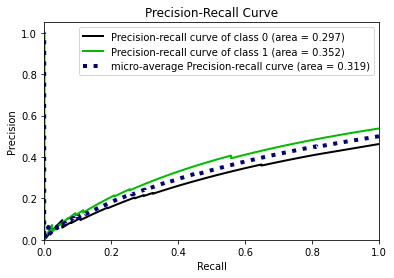

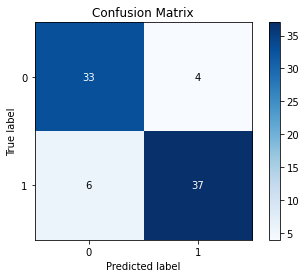

****** Classiciation report for: Previous Surgeries*********
              precision    recall  f1-score   support

     Present       0.88      1.00      0.94        61
      Absent       1.00      0.60      0.75        20

    accuracy                           0.90        81
   macro avg       0.94      0.80      0.84        81
weighted avg       0.91      0.90      0.89        81

      
      
Macro F1:  0.8442307692307692
Micro F1:  0.9012345679012346
Accuracy:  0.9012345679012346


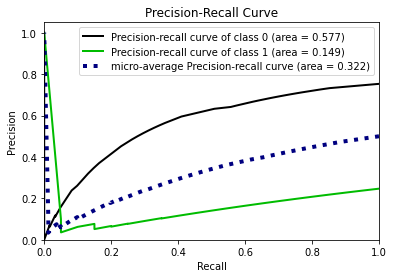

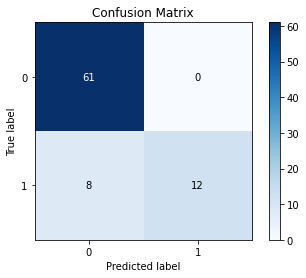

****** Classiciation report for: Disease location*********
              precision    recall  f1-score   support

     Present       0.91      0.98      0.94        42
      Absent       0.97      0.89      0.93        38

    accuracy                           0.94        80
   macro avg       0.94      0.94      0.94        80
weighted avg       0.94      0.94      0.94        80

      
      
Macro F1:  0.9370177924736262
Micro F1:  0.9375
Accuracy:  0.9375


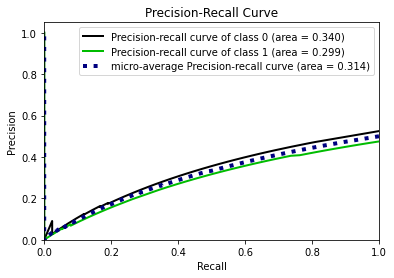

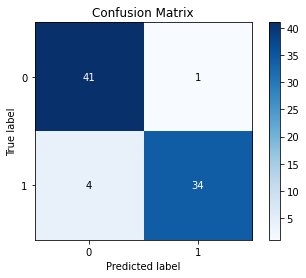

In [50]:
print("****** Classiciation report for: Abnormal Findings" + "*********")
clf_repAF = classification_report(y_testAF, predsAF, target_names = ['Present', 'Absent'])
print(clf_repAF)
print("      ")
print("      ")
macro_f1, micro_f1, acc = compute_metrics(y_testAF, predsAF)
print("Macro F1: ", macro_f1)
print("Micro F1: ", micro_f1)
print("Accuracy: ", acc)

skplt.metrics.plot_precision_recall(y_testAF.tolist(), probasAF)
skplt.metrics.plot_confusion_matrix(y_testAF, predsAF)
plt.show()


print("****** Classiciation report for: Previous Surgeries" + "*********")
clf_repPS = classification_report(y_testPS, predsPS, target_names = ['Present', 'Absent'])
print(clf_repPS)
print("      ")
print("      ")
macro_f1, micro_f1, acc = compute_metrics(y_testPS, predsPS)
print("Macro F1: ", macro_f1)
print("Micro F1: ", micro_f1)
print("Accuracy: ", acc)

skplt.metrics.plot_precision_recall(y_testPS.tolist(), probasPS)
skplt.metrics.plot_confusion_matrix(y_testPS, predsPS)
plt.show()


print("****** Classiciation report for: Disease location" + "*********")
clf_repDL = classification_report(y_testDL, predsDL, target_names = ['Present', 'Absent'])
print(clf_repDL)
print("      ")
print("      ")
macro_f1, micro_f1, acc = compute_metrics(y_testDL, predsDL)
print("Macro F1: ", macro_f1)
print("Micro F1: ", micro_f1)
print("Accuracy: ", acc)

skplt.metrics.plot_precision_recall(y_testDL.tolist(), probasDL)
skplt.metrics.plot_confusion_matrix(y_testDL, predsDL)
plt.show()

## Now all organs

In [57]:
# COMBINING Abnormal Findings csv liver with abnormal findings csv pancreas
abnormal_findings = getFiles('Abnormal Findings', dataList)
dfs_abnormalList = cleanDocs(abnormal_findings)
dfs_abnormal_findings = pd.concat(dfs_abnormalList)

# same as above but for previous surgeries csv's
prevsurg = getFiles('Previous Surgeries', dataList)
dfs_prevsurgList = cleanDocs(prevsurg)
dfs_prevsurg = pd.concat(dfs_prevsurgList)

# same as above but for disease location csv's
disloc = getFiles('disease_location', dataList)
dfs_dislocList = cleanDocs(disloc)
dfs_disloc = pd.concat(dfs_dislocList)

### data splitting

In [58]:
# abnormal findings
X_trainAF, X_testAF, y_trainAF, y_testAF = model_selection.train_test_split(dfs_abnormal_findings['sentence'],
                                                                            dfs_abnormal_findings['label'],
                                                                            test_size=0.2)

# previous surgeries
X_trainPS, X_testPS, y_trainPS, y_testPS = model_selection.train_test_split(dfs_prevsurg['sentence'],
                                                                            dfs_prevsurg['label'],
                                                                            test_size=0.2)

# disease location
X_trainDL, X_testDL, y_trainDL, y_testDL = model_selection.train_test_split(dfs_disloc['sentence'],
                                                                            dfs_disloc['label'],
                                                                            test_size=0.2)

In [59]:
# predict and train
AbnormalFindings_classifier = Classifier([1, 0], multilabel=False)
AbnormalFindings_classifier.fit(X_trainAF, y_trainAF)
predsAF, pred_probsAF, probasAF = AbnormalFindings_classifier.predict(X_testAF)

PreviousSurgeries_classifier = Classifier([1,0], multilabel=False)
PreviousSurgeries_classifier.fit(X_trainPS, y_trainPS)
predsPS, pred_probsPS, probasPS = PreviousSurgeries_classifier.predict(X_testPS)

DiseaseLocation_classifier = Classifier([1,0], multilabel=False)
DiseaseLocation_classifier.fit(X_trainDL, y_trainDL)
predsDL, pred_probsDL, probasDL = DiseaseLocation_classifier.predict(X_testDL)

In [60]:
# cleaning up predictions. from [[1],[0],...] to [1, 0,...]
predsAF = [el[0] for el in predsAF]
predsPS = [el[0] for el in predsPS]
predsDL = [el[0] for el in predsDL]

****** Classiciation report for: Abnormal Findings*********
              precision    recall  f1-score   support

     Present       0.88      0.93      0.91       345
      Absent       0.68      0.55      0.61        95

    accuracy                           0.85       440
   macro avg       0.78      0.74      0.76       440
weighted avg       0.84      0.85      0.84       440

      
      
Macro F1:  0.7568439198607708
Micro F1:  0.8477272727272728
Accuracy:  0.8477272727272728


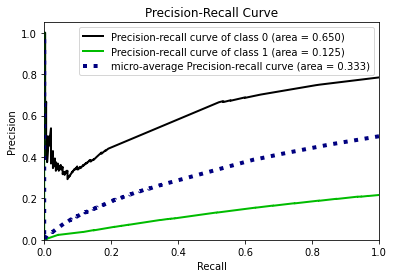

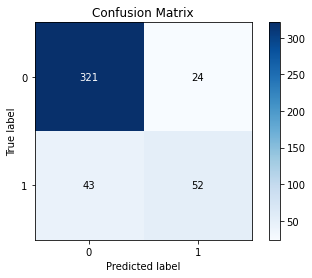

****** Classiciation report for: Previous Surgeries*********
              precision    recall  f1-score   support

     Present       0.95      0.98      0.97       410
      Absent       0.61      0.35      0.45        31

    accuracy                           0.94       441
   macro avg       0.78      0.67      0.71       441
weighted avg       0.93      0.94      0.93       441

      
      
Macro F1:  0.7082833133253301
Micro F1:  0.9387755102040817
Accuracy:  0.9387755102040817


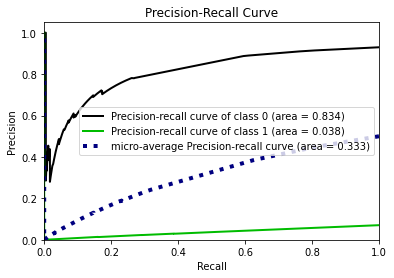

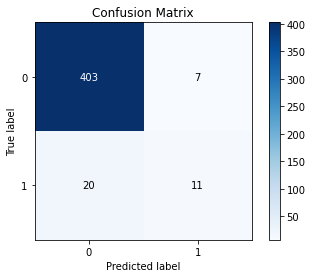

****** Classiciation report for: Disease location*********
              precision    recall  f1-score   support

     Present       0.93      0.99      0.96       398
      Absent       0.87      0.31      0.46        42

    accuracy                           0.93       440
   macro avg       0.90      0.65      0.71       440
weighted avg       0.93      0.93      0.91       440

      
      
Macro F1:  0.709236639594125
Micro F1:  0.9295454545454546
Accuracy:  0.9295454545454546


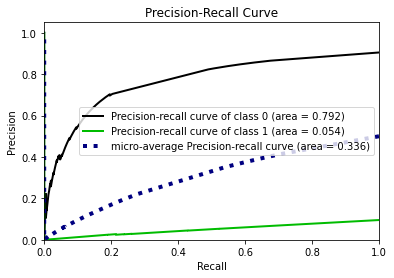

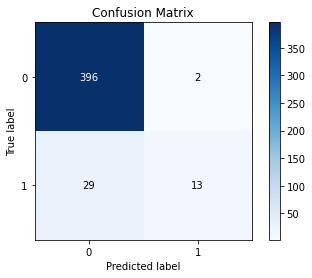

In [61]:
print("****** Classiciation report for: Abnormal Findings" + "*********")
clf_repAF = classification_report(y_testAF, predsAF, target_names = ['Present', 'Absent'])
print(clf_repAF)
print("      ")
print("      ")
macro_f1, micro_f1, acc = compute_metrics(y_testAF, predsAF)
print("Macro F1: ", macro_f1)
print("Micro F1: ", micro_f1)
print("Accuracy: ", acc)

skplt.metrics.plot_precision_recall(y_testAF.tolist(), probasAF)
skplt.metrics.plot_confusion_matrix(y_testAF, predsAF)
plt.show()


print("****** Classiciation report for: Previous Surgeries" + "*********")
clf_repPS = classification_report(y_testPS, predsPS, target_names = ['Present', 'Absent'])
print(clf_repPS)
print("      ")
print("      ")
macro_f1, micro_f1, acc = compute_metrics(y_testPS, predsPS)
print("Macro F1: ", macro_f1)
print("Micro F1: ", micro_f1)
print("Accuracy: ", acc)

skplt.metrics.plot_precision_recall(y_testPS.tolist(), probasPS)
skplt.metrics.plot_confusion_matrix(y_testPS, predsPS)
plt.show()


print("****** Classiciation report for: Disease location" + "*********")
clf_repDL = classification_report(y_testDL, predsDL, target_names = ['Present', 'Absent'])
print(clf_repDL)
print("      ")
print("      ")
macro_f1, micro_f1, acc = compute_metrics(y_testDL, predsDL)
print("Macro F1: ", macro_f1)
print("Micro F1: ", micro_f1)
print("Accuracy: ", acc)

skplt.metrics.plot_precision_recall(y_testDL.tolist(), probasDL)
skplt.metrics.plot_confusion_matrix(y_testDL, predsDL)
plt.show()